The following notebook is based on notebook found on https://github.com/shoji9x9/Fashion-MNIST-By-ResNet.

## 0. Install TensorFlow 2.0

In [0]:
!pip install tensorflow-gpu==2.0.0
!pip install numpy

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 450kB 65.2MB/s 
     |████████████████████████████████| 3.8MB 74.4MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goo

## 1. Prepare dataset

In [0]:
# Downloading Dataset
import tensorflow_datasets as tfds
import tensorflow as tf

dataset, info = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
dataset_test, dataset_train = dataset['test'], dataset['train']
print(info)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteRUTLAZ/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteRUTLAZ/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashio

In [0]:
#Normalizing and shufling data
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 128

dataset_train = dataset_train.map(convert_types).shuffle(10000).batch(batch_size)
dataset_test = dataset_test.map(convert_types).batch(batch_size)

## 2. Data Augmentation

In [0]:
# Creating data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

## 3. Define model

In [0]:
# Defining model
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model

class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()
        
        channel = channel_out // 4
        
        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)
        
    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y
    
    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)
        
    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
           
class ResNet50(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()                
        
        self._layers = [
            # conv1
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu), # [1,14,14,64]
            # conv2_x
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"), # [1, 7, 7, 64]
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)                
            ],
            # conv3_x
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)), # [1, 4, 4, 512]
            [
                ResidualBlock(512, 512) for _ in range(4)                
            ],
            # conv4_x
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)), # [1,2,2,1024]
            [
                ResidualBlock(1024, 1024) for _ in range(6)                
            ],
            # conv5_x
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)), #[1,1,1,2048]
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],
            # last part
            GlobalAveragePooling2D(),
            Dense(1000, activation = tf.nn.relu),
            Dense(output_dim, activation = tf.nn.softmax)
        ]
        
    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)    
            else:
                x = layer(x)
        return x
       
    
model = ResNet50((28, 28, 1), 10)
model.build(input_shape = (None, 28, 28, 1))
model.summary()

Model: "res_net50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3200      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
residual_block (ResidualBloc multiple                  75904     
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  71552     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  71

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

## 4. Prepare training

In [0]:
# Defining keras metrics
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

In [0]:
# Defining training and test steps
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(label, predictions)
        
@tf.function
def test_step(image, label):
    predictions = model(image)
    loss = loss_object(label, predictions)
    
    test_loss(loss)
    test_accuracy(label, predictions)

## 5. Train

In [0]:
# Training
import time

num_epoch = 200
start_time = time.time()

train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
for epoch in range(num_epoch):
    print("epoch" + str(epoch))  
    for image, label in dataset_train:
        for _image, _label in datagen.flow(image, label, batch_size = batch_size):
            train_step(_image, _label)
            break
        
    for test_image, test_label in dataset_test:
        test_step(test_image, test_label)
        
    train_accuracies.append(train_accuracy.result())
    test_accuracies.append(test_accuracy.result())    
    train_losses.append(train_loss.result())
    test_losses.append(test_loss.result())

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, spent_time: {} min'
    spent_time = time.time() - start_time
    print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100, spent_time / 60))

epoch0
Epoch 1, Loss: 0.6500788927078247, Accuracy: 75.30000305175781, Test Loss: 0.42581847310066223, Test Accuracy: 84.87999725341797, spent_time: 0.9057244658470154 min
epoch1
Epoch 2, Loss: 0.5176789164543152, Accuracy: 80.55750274658203, Test Loss: 0.40216347575187683, Test Accuracy: 85.59500122070312, spent_time: 1.4901367147763571 min
epoch2
Epoch 3, Loss: 0.4560428559780121, Accuracy: 83.0022201538086, Test Loss: 0.383931040763855, Test Accuracy: 86.24666595458984, spent_time: 2.0826255242029825 min
epoch3
Epoch 4, Loss: 0.4184049665927887, Accuracy: 84.49708557128906, Test Loss: 0.37165597081184387, Test Accuracy: 86.60749816894531, spent_time: 2.6637442111968994 min
epoch4
Epoch 5, Loss: 0.3930518627166748, Accuracy: 85.45633697509766, Test Loss: 0.3609696328639984, Test Accuracy: 87.04199981689453, spent_time: 3.258003866672516 min
epoch5
Epoch 6, Loss: 0.37380364537239075, Accuracy: 86.18639373779297, Test Loss: 0.35090747475624084, Test Accuracy: 87.4566650390625, spent_ti

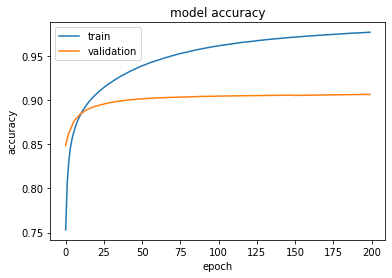

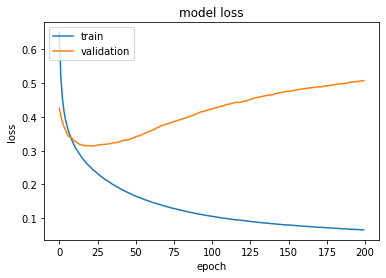

In [0]:
# Ploting code from https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy user Simone
import matplotlib.pyplot as plt

plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Saving and loading model

In [0]:
weights = model.get_weights() 

In [0]:
import pickle
filehandler = open("weights.obj","wb")
pickle.dump(weights,filehandler)
filehandler.close()

In [0]:
file = open("weights.obj",'rb')
object_file = pickle.load(file)
file.close()

In [0]:
new_model = ResNet50((28, 28, 1), 10)
new_model.build(input_shape = (None, 28, 28, 1))

In [0]:
new_model.set_weights(weights)

In [0]:
#Evaluate on test set
import numpy as np
accs = []
for test_image, test_label in dataset_test:
        #test_im_rot = tf.image.rot90(test_image, k=0, name=None)
        test_im_rot = test_image
        predictions = new_model(test_im_rot)
        acc = tf.math.equal(tf.math.argmax(input = predictions, axis=1), test_label).numpy().mean()
        accs.append(acc)

print(np.array(accs).mean())

0.907931170886076


In [0]:
#Evaluate on test set rotated 90 degree
import numpy as np
accs = []
for test_image, test_label in dataset_test:
        test_im_rot = tf.image.rot90(test_image, k=1, name=None)
        #test_im_rot = test_image
        predictions = new_model(test_im_rot)
        acc = tf.math.equal(tf.math.argmax(input = predictions, axis=1), test_label).numpy().mean()
        accs.append(acc)

print(np.array(accs).mean())


0.0669501582278481


In [0]:
#Evaluate on test set rotated 180 degree
import numpy as np
accs = []
for test_image, test_label in dataset_test:
        test_im_rot = tf.image.rot90(test_image, k=2, name=None)
        #test_im_rot = test_image
        predictions = new_model(test_im_rot)
        acc = tf.math.equal(tf.math.argmax(input = predictions, axis=1), test_label).numpy().mean()
        accs.append(acc)

print(np.array(accs).mean())

0.22735363924050633


In [0]:
#Evaluate on test set rotated 270 degree
import numpy as np
accs = []
for test_image, test_label in dataset_test:
        test_im_rot = tf.image.rot90(test_image, k=3, name=None)
        #test_im_rot = test_image
        predictions = new_model(test_im_rot)
        acc = tf.math.equal(tf.math.argmax(input = predictions, axis=1), test_label).numpy().mean()
        accs.append(acc)

print(np.array(accs).mean())

0.0535996835443038
